# Linear Models UQ Example

This notebook demonstrates the use of linear datasets, models, and UQ methods in the UQ Encyclopedia framework.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../..')

from src.datasets.linear import LineDataset, PolynomialDataset
from src.models.linear_models import OLSRegression
from src.uq_methods.linear_uq import HatMatrixUQ, BayesianLinearRegressionUQ, ConformalPredictionUQ
from src.visualization import setup_plot_style, plot_predictions_with_intervals, plot_method_comparison_bars
from src.metrics import picp, mean_interval_width, root_mean_squared_error
from src.utils.seeds import set_global_seed

# Set up plotting
setup_plot_style()
%matplotlib inline

## 1. Generate Dataset

Let's start with a simple line dataset with noise.

In [2]:
# Set random seed for reproducibility
set_global_seed(42)

# Create line dataset
dataset = LineDataset(
    slope=0.8,
    intercept=0.1,
    n_samples=100,
    noise_model='homoskedastic',
    noise_level=0.05,  # 5% noise
    seed=42
)

# Generate data
data = dataset.generate()

# Print information
print(f"Training samples: {len(data.X_train)}")
print(f"Test samples: {len(data.X_test)}")
print(f"Gap samples: {len(data.X_gap)}")
print(f"\nDataset metadata:")
print(dataset.get_metadata())

Training samples: 51
Test samples: 500
Gap samples: 25

Dataset metadata:
DatasetMetadata(name='LineDataset', family='linear', function_form='y = 0.80x + 0.10', n_samples=100, domain=(0.0, 1.0), gap_fraction=0.25, extrapolation_fraction=(0.125, 0.125), noise_model='homoskedastic', noise_level=0.05, seed=42, parameters={'slope': 0.8, 'intercept': 0.1})


## 2. Visualize Dataset

Let's visualize the dataset with training data, gap, and extrapolation regions.

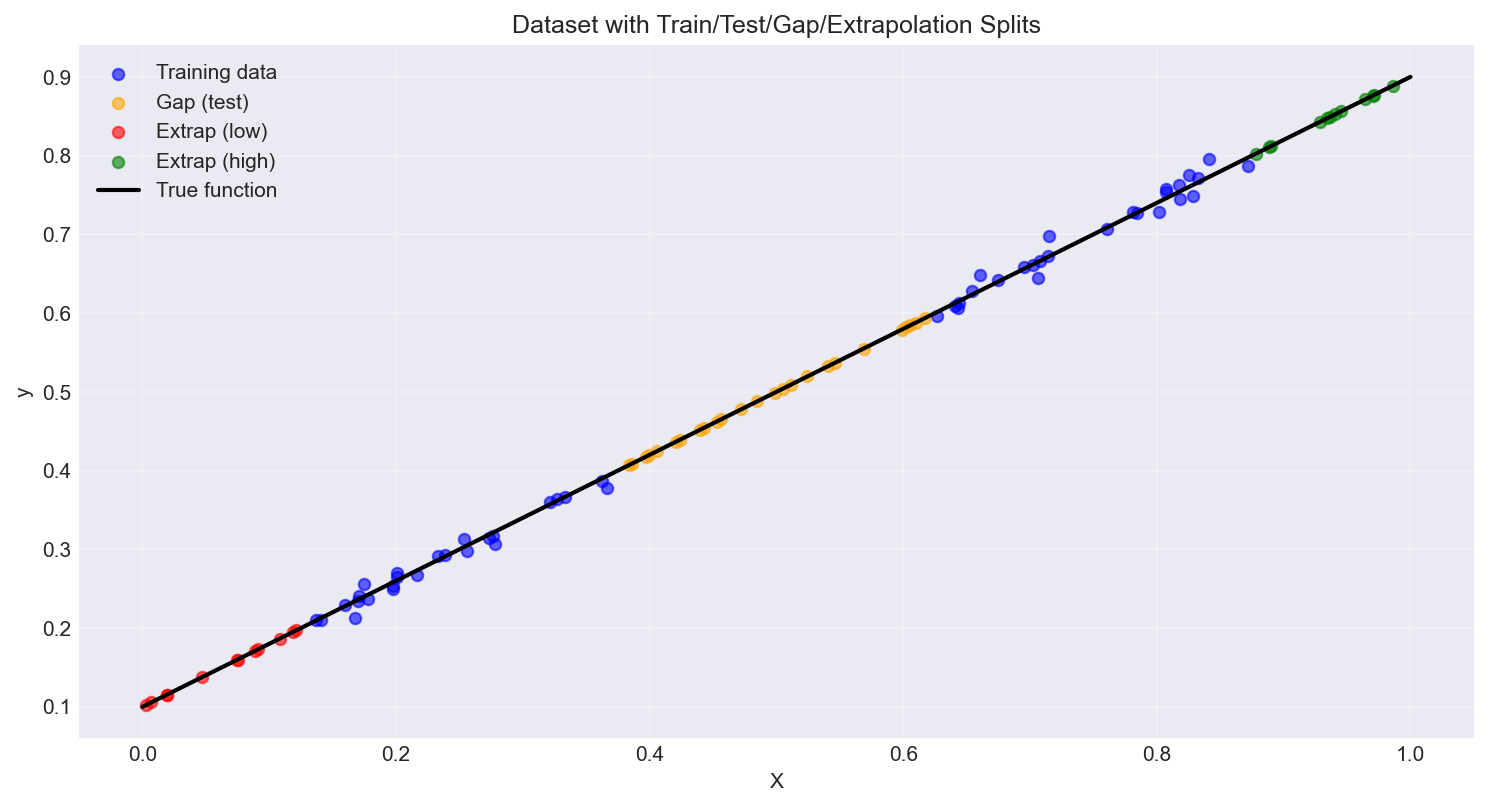

In [3]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot different regions
ax.scatter(data.X_train, data.y_train, alpha=0.6, s=30, label='Training data', color='blue')
ax.scatter(data.X_gap, data.y_gap, alpha=0.6, s=30, label='Gap (test)', color='orange')
ax.scatter(data.X_extrap_low, data.y_extrap_low, alpha=0.6, s=30, label='Extrap (low)', color='red')
ax.scatter(data.X_extrap_high, data.y_extrap_high, alpha=0.6, s=30, label='Extrap (high)', color='green')

# Plot true function
X_plot = np.linspace(0, 1, 200).reshape(-1, 1)
y_plot = dataset._generate_clean(X_plot.flatten())
ax.plot(X_plot, y_plot, 'k-', linewidth=2, label='True function', zorder=10)

ax.set_xlabel('X')
ax.set_ylabel('y')
ax.set_title('Dataset with Train/Test/Gap/Extrapolation Splits')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

## 3. Fit Model

Fit a simple linear regression model.

In [4]:
# Create and fit model
model = OLSRegression(degree=1, fit_intercept=True)
model.fit(data.X_train, data.y_train)

# Print fitted coefficients
print(f"Fitted coefficients: {model.coef_}")
print(f"True coefficients: [intercept={dataset.intercept}, slope={dataset.slope}]")
print(f"\nResidual variance: {model.sigma_squared_:.4f}")

Fitted coefficients: [0.09705078 0.80595645]
True coefficients: [intercept=0.1, slope=0.8]

Residual variance: 0.0001


## 4. Apply UQ Methods

Apply three different UQ methods: Hat Matrix, Bayesian, and Conformal Prediction.

In [5]:
# Initialize UQ methods
hat_uq = HatMatrixUQ(confidence_level=0.95)
bay_uq = BayesianLinearRegressionUQ(confidence_level=0.95)
conf_uq = ConformalPredictionUQ(confidence_level=0.95, method='plus')

# Compute uncertainty intervals
result_hat = hat_uq.compute_intervals(model, data.X_train, data.y_train, data.X_test)
result_bay = bay_uq.compute_intervals(model, data.X_train, data.y_train, data.X_test)
result_conf = conf_uq.compute_intervals(model, data.X_train, data.y_train, data.X_test)

results = {
    'Hat Matrix': result_hat,
    'Bayesian': result_bay,
    'Conformal': result_conf,
}

print("UQ methods applied successfully!")

UQ methods applied successfully!


/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/mapie/estimator/regressor.py:300: RuntimeWarning: divide by zero encountered in matmul
  return np.matmul(x, (K / (K.sum(axis=1, keepdims=True))).T)
/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/mapie/estimator/regressor.py:300: RuntimeWarning: overflow encountered in matmul
  return np.matmul(x, (K / (K.sum(axis=1, keepdims=True))).T)
/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/mapie/estimator/regressor.py:300: RuntimeWarning: invalid value encountered in matmul
  return np.matmul(x, (K / (K.sum(axis=1, keepdims=True))).T)


## 5. Visualize Predictions with Uncertainty

Plot predictions with uncertainty intervals for each method.

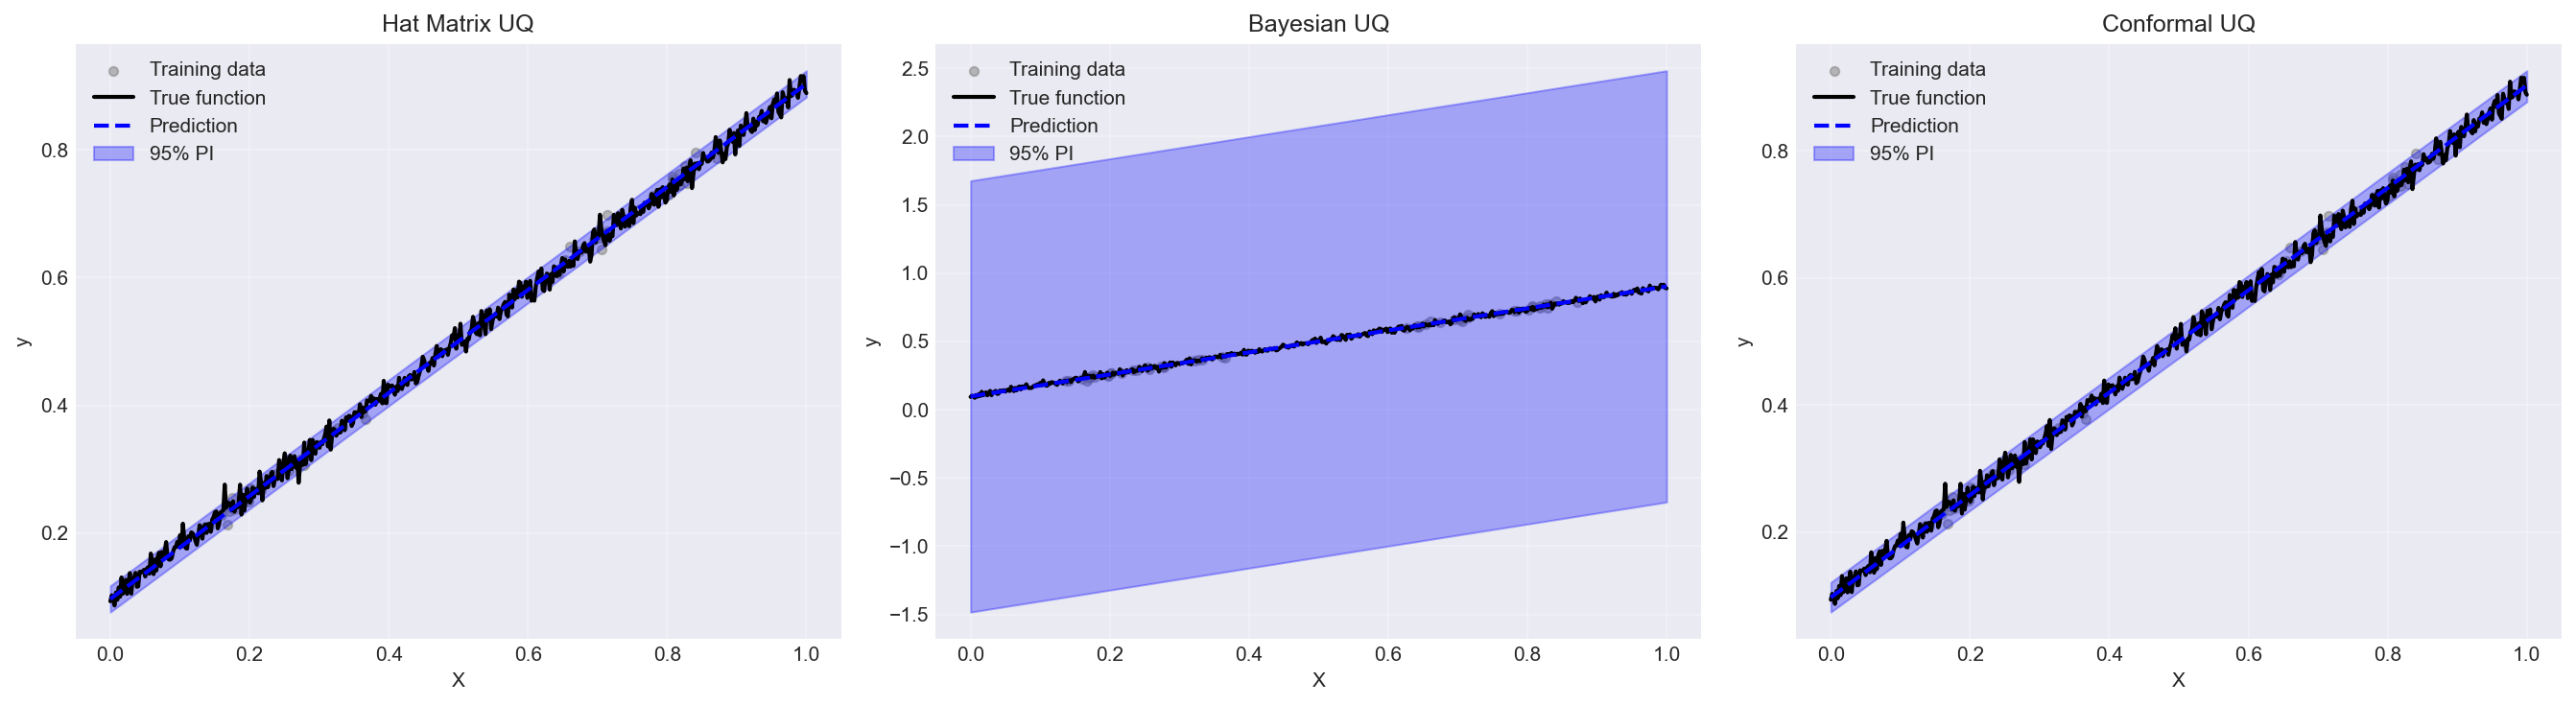

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (method_name, result) in zip(axes, results.items()):
    plot_predictions_with_intervals(
        data.X_test,
        data.y_test,
        result,
        X_train=data.X_train,
        y_train=data.y_train,
        title=f'{method_name} UQ',
        ax=ax
    )

plt.tight_layout()
plt.show()

## 6. Evaluate Metrics

Compute and compare metrics across all methods.

In [7]:
import pandas as pd

# Compute metrics for each method
metrics_data = []

for method_name, result in results.items():
    metrics = {
        'Method': method_name,
        'Coverage': picp(data.y_test, result),
        'RMSE': root_mean_squared_error(data.y_test, result.y_pred),
        'Mean Width': mean_interval_width(result.y_lower, result.y_upper),
    }
    metrics_data.append(metrics)

# Create DataFrame
df_metrics = pd.DataFrame(metrics_data)
print("\nMetrics Comparison:")
print(df_metrics.to_string(index=False))
print(f"\nTarget coverage: 0.95")


Metrics Comparison:
    Method  Coverage     RMSE  Mean Width
Hat Matrix      0.92 0.011568    0.040764
  Bayesian      1.00 0.011566    3.159487
 Conformal      0.96 0.011567    0.048644

Target coverage: 0.95


## 7. Compare Methods Visually

Create bar plots comparing the methods.

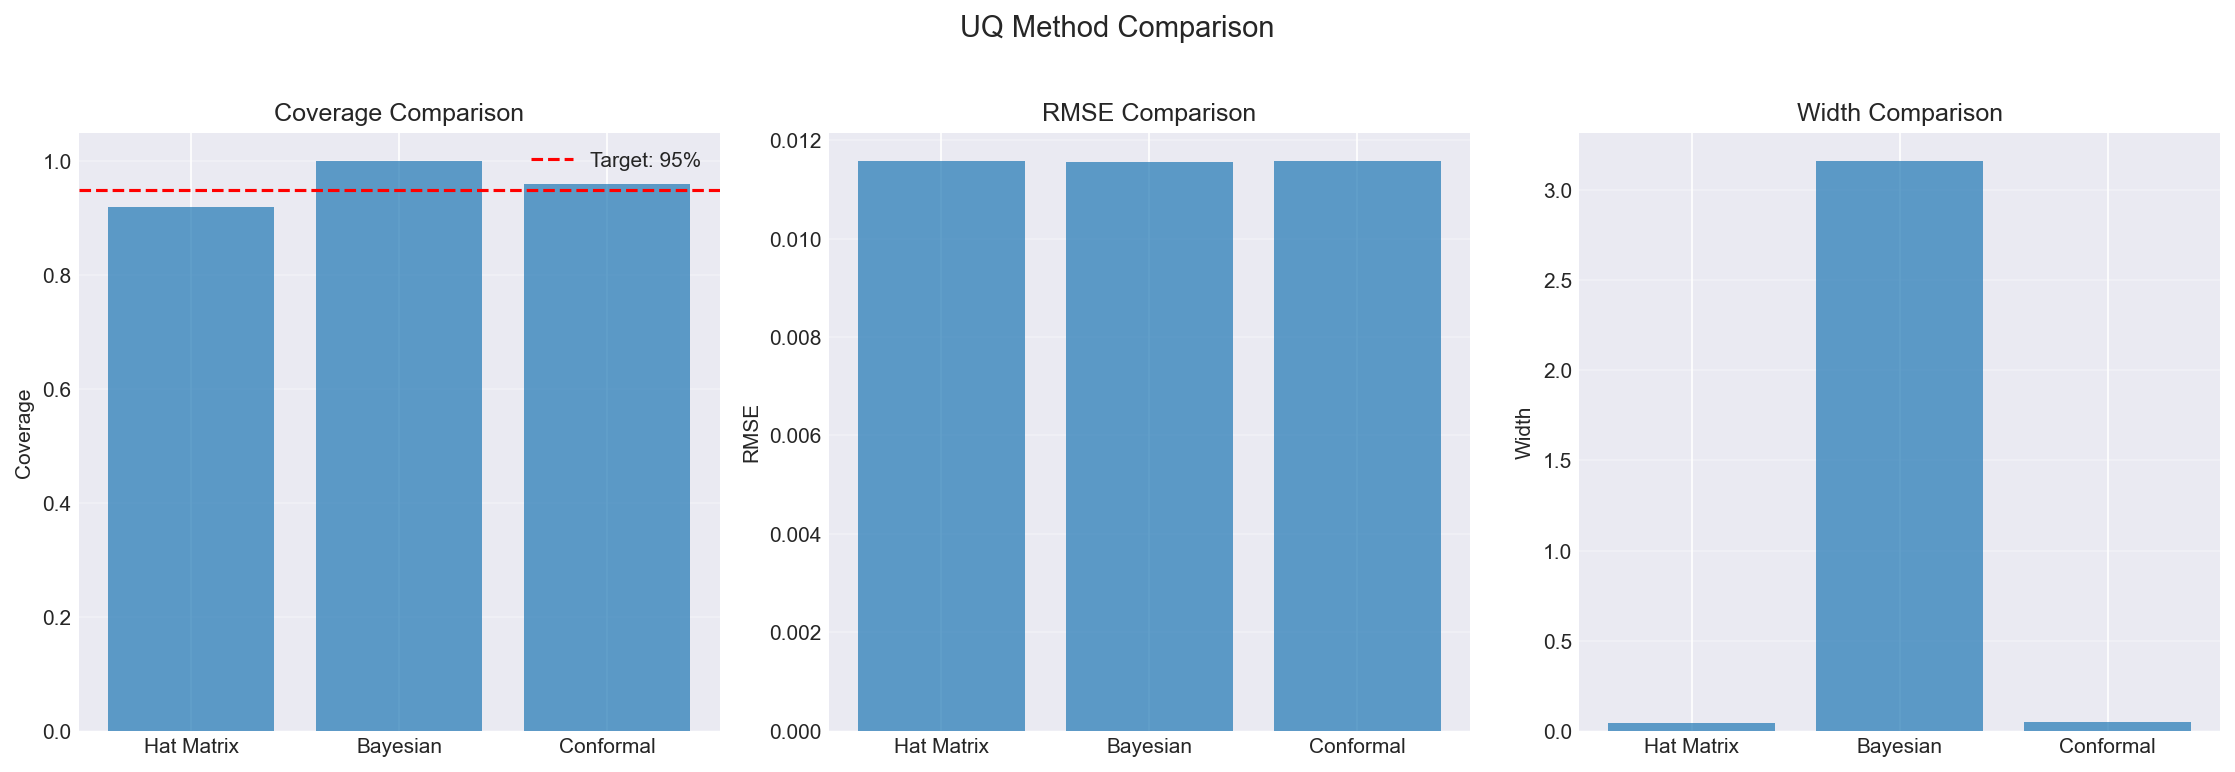

In [8]:
fig = plot_method_comparison_bars(
    data.y_test,
    results,
    metrics=['Coverage', 'RMSE', 'Width'],
    title='UQ Method Comparison'
)
plt.show()

## 8. Evaluate Coverage by Region

Check if coverage is consistent across interpolation and extrapolation regions.

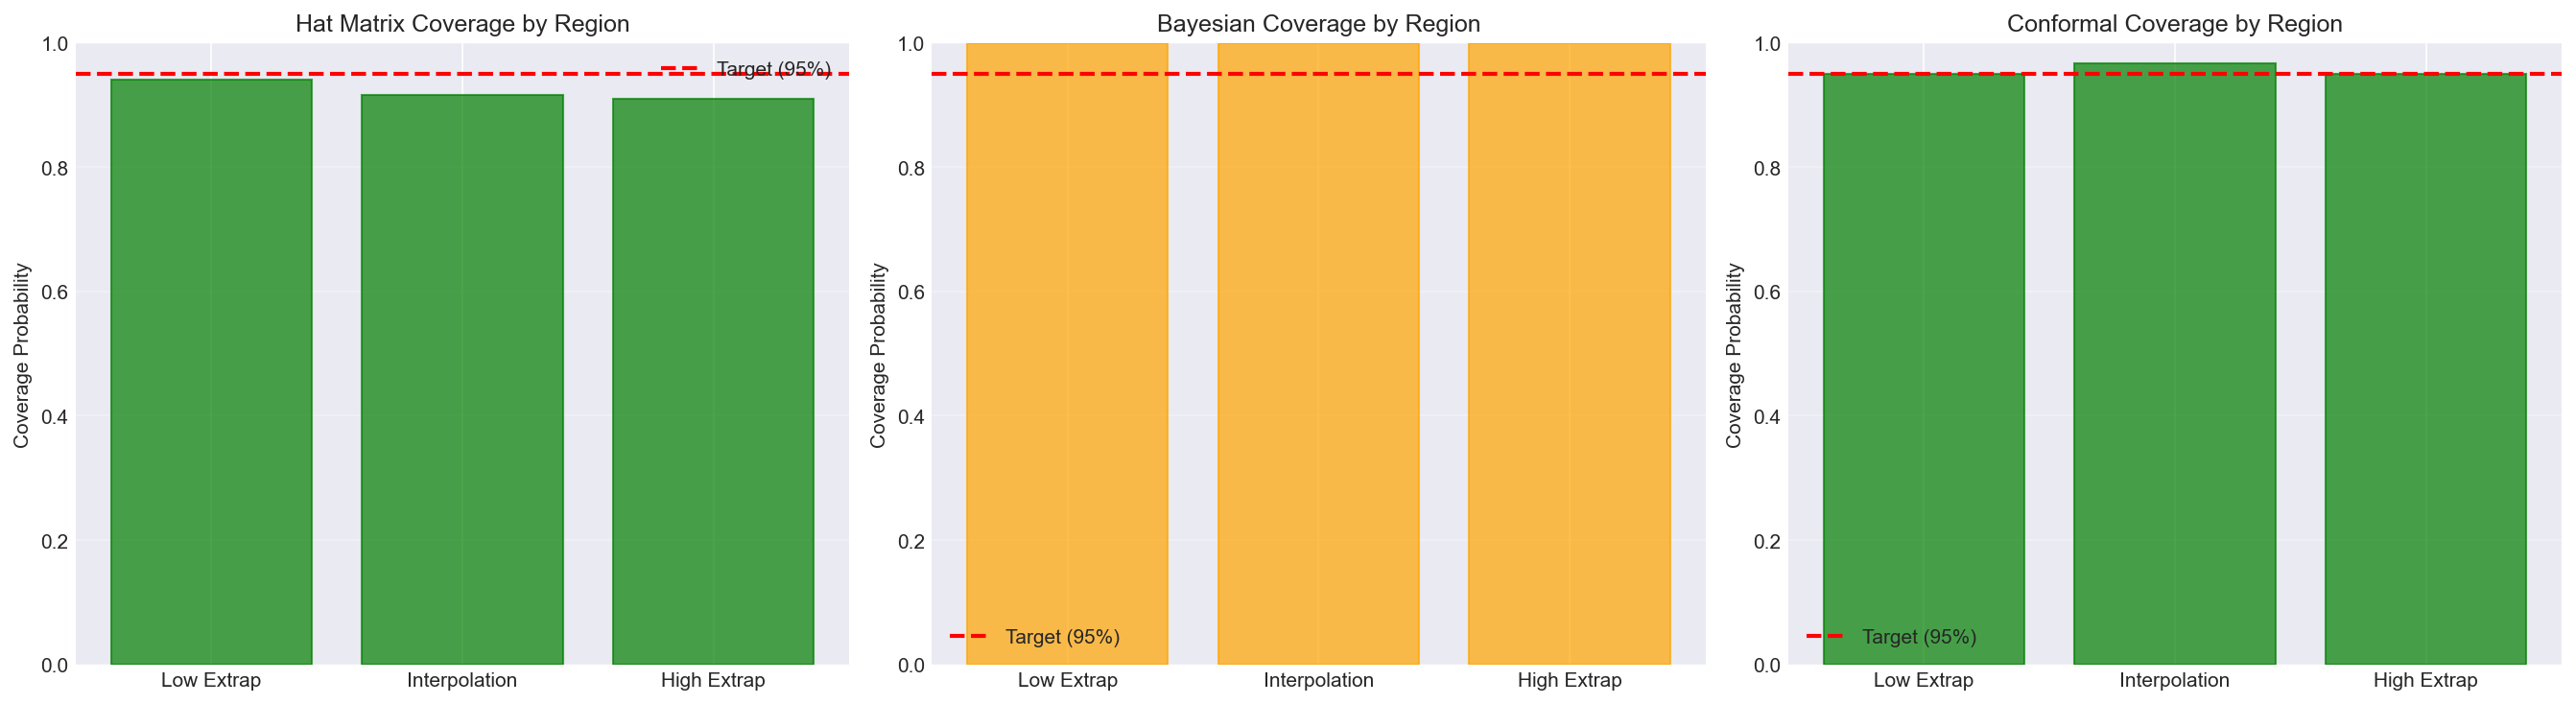

In [9]:
from src.visualization.plots import plot_coverage_by_region

# Define regions based on X values
X_flat = data.X_test.flatten()
regions = {
    'Low Extrap': X_flat < 0.2,
    'Interpolation': (X_flat >= 0.2) & (X_flat <= 0.8),
    'High Extrap': X_flat > 0.8,
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (method_name, result) in zip(axes, results.items()):
    plot_coverage_by_region(
        data.X_test,
        data.y_test,
        result,
        regions,
        title=f'{method_name} Coverage by Region',
        ax=ax
    )

plt.tight_layout()
plt.show()

## 9. Try Different Dataset: Polynomial

Let's try a more complex polynomial dataset.

/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/linear_m

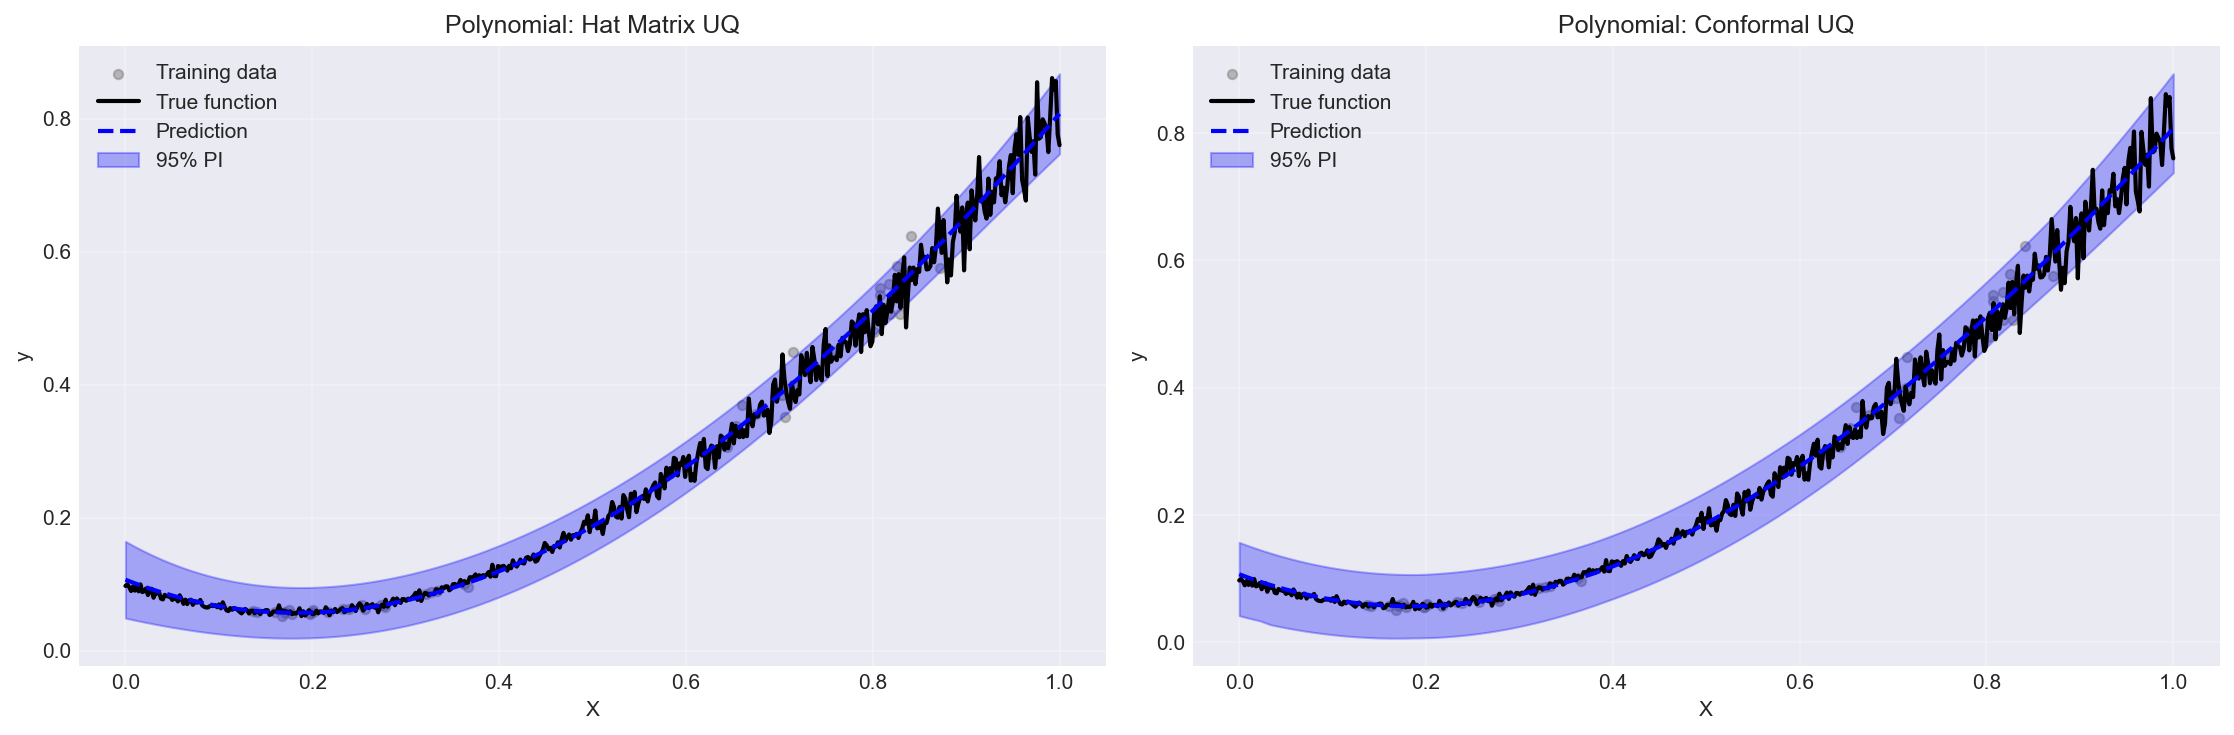


Polynomial Coverage (Hat Matrix): 0.960
Polynomial Coverage (Conformal): 0.980


In [10]:
# Create polynomial dataset
poly_dataset = PolynomialDataset(
    degree=3,
    n_samples=100,
    noise_model='heteroskedastic',
    noise_level=0.05,
    seed=42
)

# Generate data
poly_data = poly_dataset.generate()

# Fit cubic model
poly_model = OLSRegression(degree=3, fit_intercept=True)
poly_model.fit(poly_data.X_train, poly_data.y_train)

# Apply UQ methods
poly_result_hat = hat_uq.compute_intervals(
    poly_model, poly_data.X_train, poly_data.y_train, poly_data.X_test
)
poly_result_conf = conf_uq.compute_intervals(
    poly_model, poly_data.X_train, poly_data.y_train, poly_data.X_test
)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_predictions_with_intervals(
    poly_data.X_test, poly_data.y_test, poly_result_hat,
    X_train=poly_data.X_train, y_train=poly_data.y_train,
    title='Polynomial: Hat Matrix UQ',
    ax=axes[0]
)

plot_predictions_with_intervals(
    poly_data.X_test, poly_data.y_test, poly_result_conf,
    X_train=poly_data.X_train, y_train=poly_data.y_train,
    title='Polynomial: Conformal UQ',
    ax=axes[1]
)

plt.tight_layout()
plt.show()

print(f"\nPolynomial Coverage (Hat Matrix): {picp(poly_data.y_test, poly_result_hat):.3f}")
print(f"Polynomial Coverage (Conformal): {picp(poly_data.y_test, poly_result_conf):.3f}")

## Summary

This notebook demonstrated:

1. **Dataset Generation**: Creating linear datasets with controlled noise and train/test/gap splits
2. **Model Fitting**: Fitting OLS regression models with different polynomial degrees
3. **UQ Methods**: Applying three different UQ methods (Hat Matrix, Bayesian, Conformal)
4. **Visualization**: Plotting predictions with uncertainty intervals
5. **Metrics**: Evaluating coverage, RMSE, and interval width
6. **Regional Analysis**: Checking coverage in different regions (interpolation vs extrapolation)

Key observations:
- All methods should achieve approximately 95% coverage on the test set
- Conformal prediction provides distribution-free guarantees
- Hat matrix method is fast but assumes normally distributed errors
- Bayesian method provides probabilistic interpretation